In [ ]:
#Get Manhattan, Tanimoto distance between the bit vectors of the compounds

In [28]:
import os

import pandas as pd
import numpy as np
import enlighten

from IPython.core.display import HTML
from IPython.display import SVG, Image, display

from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit import DataStructs


In [5]:
def show(df):
    return HTML(df.to_html(notebook=True))

In [2]:
assay = 1511

In [3]:
#load sdf
sdfpath = os.path.join(os.getcwd(), f'{assay}_compounds.sdf')
dataset = PandasTools.LoadSDF(sdfpath)

[09:47:15] WARNING: not removing hydrogen atom without neighbors
[09:47:16] WARNING: not removing hydrogen atom without neighbors


,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CANONICAL_SMILES,ID,ROMol
0,1511,56314828,1988,Inactive,CCC1=CC=CC(=C1N(COCC)C(=O)CCl)C,,
1,1511,56321651,425322,Inactive,C1CCC(CC1)NC(=O)C2COC3=CC=CC=C3O2,,
2,1511,56322145,24981957,Inactive,C1CN(CCN1CC2=CC=CC=C2)S(=O)(=O)C3=CC=CC(=C3)C(...,,
3,1511,51090143,7384392,Inactive,CCS(=O)(=O)N1CCC2(CC1)N(CCO2)S(=O)(=O)C3=CC=C(...,,

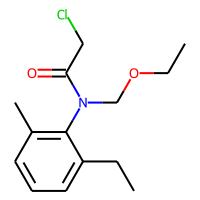
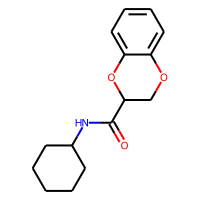
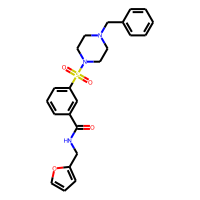
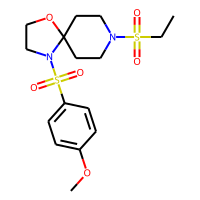

In [6]:
show(dataset.head(4))

In [13]:
all_mol = dataset.copy()



In [18]:
all_mol["MACCS_keys"] = np.nan


In [24]:
#get MACCS keys and add them to the dataframe
pbar = enlighten.Counter(total=len(all_mol.index), desc='Getting MACCS keys...', unit='tick')

for index, row in all_mol.iterrows():
    mol = row.ROMol
    maccs = Chem.GetMACCSKeysFingerprint(mol)
    all_mol.loc[index, "MACCS_keys"] = maccs
    pbar.update()

In [76]:
actives = all_mol[all_mol["PUBCHEM_ACTIVITY_OUTCOME"] == "Active"]

In [44]:
active_MACCS = actives.MACCS_keys.to_list()
all_MACCS = all_mol.MACCS_keys.to_list()

In [45]:
#Setup empty matrix
tanimoto_coefficients = np.zeros([len(active_MACCS), len(all_MACCS)])
tanimoto_coefficients.shape

(1552, 305679)

In [47]:
#calculate the tanimoto coefficents for each molecule pair
TM_bar = enlighten.Counter(total=len(actives.index), desc="Calculating Tanimoto similarities...", unit='tick')

for i_ID, i in enumerate(active_MACCS):
    for j_ID, j in enumerate(all_MACCS):
        #metric is unnecessary, 
        TM_sim = DataStructs.FingerprintSimilarity(i, j, metric=DataStructs.TanimotoSimilarity)
        tanimoto_coefficients[i_ID, j_ID] = TM_sim
    TM_bar.update()


In [ ]:
#setup actives dataframe
# actives = actives.assign(mol_1=np.nan, mol_2=np.nan, mol_3=np.nan, mol_4=np.nan, mol_5=np.nan)

In [116]:
cols = ['PUBCHEM_CID', 'PUBCHEM_ACTIVITY_OUTCOME', 'ROMol']
new_cols = [
    'mol1', 'activity1', 'cid_1',
    'mol2', 'activity2', 'cid_2',
    'mol3', 'activity3', 'cid_3',
    'mol4', 'activity4', 'cid_4',
    'mol5', 'activity5', 'cid_5',
]
cols = cols + new_cols

In [100]:
print(all_cols)

['PUBCHEM_ASSAY_ID', 'PUBCHEM_SID', 'PUBCHEM_CID', 'PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_CANONICAL_SMILES', 'ID', 'ROMol', 'MACCS_keys']


In [117]:
all_cols = all_mol.columns.values.tolist()
col_indexes = [ID for ID, x in enumerate(all_cols) if x in cols]


,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,ROMol,mol1,activity1,cid_1,mol2,activity2,cid_2,mol3,activity3,cid_3,mol4,activity4,cid_4,mol5,activity5,cid_5
4890,17178962,Active,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4945,24687034,Active,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5671,24687422,Active,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9967,23704906,Active,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11083,833347,Active,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305631,649644,Active,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305635,650516,Active,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305641,649275,Active,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305659,647480,Active,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

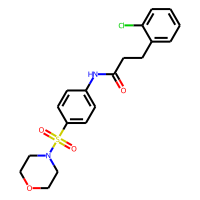
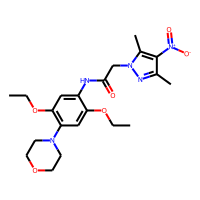
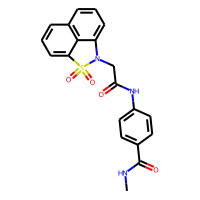
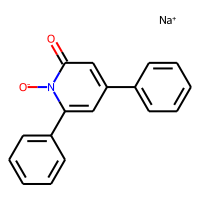
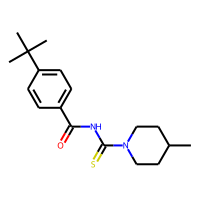
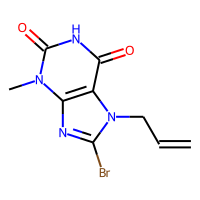
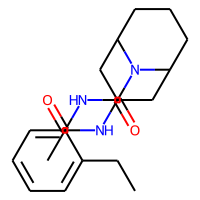
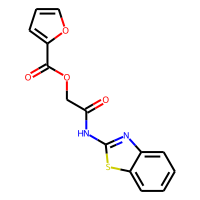
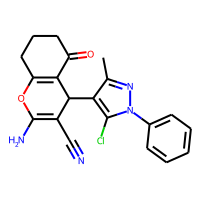
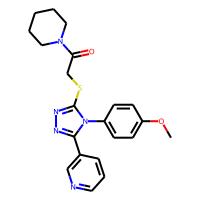

In [125]:
similarities = actives.copy()
similarities.reindex(columns=cols)

In [128]:
for ID, i in enumerate(tanimoto_coefficients):
    mol_idx = np.argsort(i)
    mol_idx = mol_idx[::-1]
    a,b,c,d,e = mol_idx[:5]
    # actives.loc[ID]
    # show(all_mol.iloc[a]) 
    # print(all_mol.iloc[a])
    # mol1, activity1, cid_1 = all_mol.iloc[a, [col_indexes]]

    # active_row = actives.iloc[ID].values.flatten().tolist()
    # active_mol, active_cid, activity_act = active_row[col_indexes[0]], row[col_indexes[1]], row[col_indexes[2]]

    #I hate how dumb this looks


    row1 = all_mol.iloc[a].values.flatten().tolist()
    mol1, activity1, cid_1 = row[col_indexes[0]], row[col_indexes[1]], row[col_indexes[2]]

    row2 = all_mol.iloc[b].values.flatten().tolist()
    mol2, activity2, cid_2 = row[col_indexes[0]], row[col_indexes[1]], row[col_indexes[2]]

    row3 = all_mol.iloc[c].values.flatten().tolist()
    mol3, activity3, cid_3 = row[col_indexes[0]], row[col_indexes[1]], row[col_indexes[2]]

    row4 = all_mol.iloc[d].values.flatten().tolist()
    mol4, activity4, cid_4 = row[col_indexes[0]], row[col_indexes[1]], row[col_indexes[2]]

    row5 = all_mol.iloc[e].values.flatten().tolist()
    mol5, activity5, cid_5 = row[col_indexes[0]], row[col_indexes[1]], row[col_indexes[2]]

    similarities.loc()

    line = [mol1, activity1, cid_1, mol2, activity2, cid_2, mol3, activity3, cid_3, mol4, activity4, cid_4, mol5, activity5, cid_5]

    similarities.loc[ID, ['mol1']] = mol1   

    break

,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CANONICAL_SMILES,ID,ROMol,MACCS_keys,mol1
4890,1511,56315515,17178962,Active,C1COCCN1S(=O)(=O)C2=CC=C(C=C2)NC(=O)CCC3=CC=CC...,,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
4945,1511,56319046,24687034,Active,CCOC1=CC(=C(C=C1NC(=O)CN2C(=C(C(=N2)C)[N+](=O)...,,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN

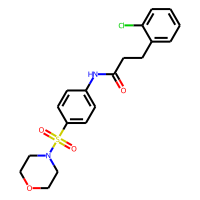
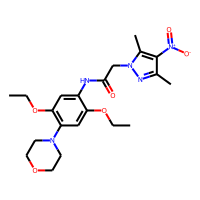

In [129]:
show(similarities.head(2))